###First, we bring in our tools and connect to our "virtual" database.

In [4]:

import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Loading the dataset
# I am reading the 50k records generated earlier into a Pandas DataFrame.
df = pd.read_csv('operational_overdue_data.csv')

# 2. Creating an In-Memory SQL Database
# I am creating a temporary SQL database so I can run SQL queries directly on my CSV data.
conn = sqlite3.connect(':memory:')
df.to_sql('operations', conn, index=False, if_exists='replace')

print("Step 1 & 2 Complete: Dataset loaded and SQL engine ready.")

Step 1 & 2 Complete: Dataset loaded and SQL engine ready.


I am using SQL here to find the "Historical Truth"—which vendor is actually the problem?

In [6]:
# 3. Running SQL Query to find Bottlenecks
# Here, I am calculating the failure rate per vendor. 
# This helps me identify which segments are "At-Risk" historically.
sql_query = """
SELECT 
    Vendor_Type,
    COUNT(*) as total_orders,
    SUM(Overdue_Flag) as total_delays,
    ROUND(AVG(Overdue_Flag) * 100, 2) as failure_rate_pct
FROM operations
GROUP BY Vendor_Type
ORDER BY failure_rate_pct DESC
"""

sql_results = pd.read_sql_query(sql_query, conn)
print("\n--- SQL Analysis: Failure Rates by Vendor ---")
print(sql_results)


--- SQL Analysis: Failure Rates by Vendor ---
   Vendor_Type  total_orders  total_delays  failure_rate_pct
0  Third-Party         15027         11467             76.31
1      Express         10119          7687             75.97
2     Internal          4950          3753             75.82
3     Standard         19904         15062             75.67


Now that I know who is failing, I use Python to find out why. I’m looking for the relationship between staff levels and delays.

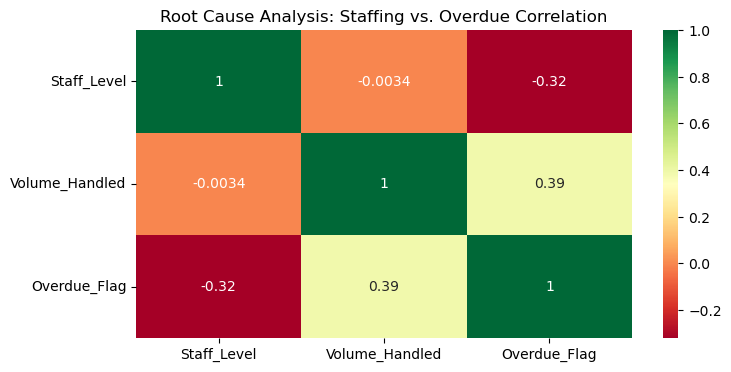


Insight: When Volume > 400 and Staff < 5, the risk of delay jumps to 100.00%


In [8]:
# 4. Correlation Heatmap
# I am checking if there is a mathematical link between Staff_Level and Overdue_Flag.
# A negative correlation here means: Lower Staff = Higher Delays.
plt.figure(figsize=(8, 4))
correlation_matrix = df[['Staff_Level', 'Volume_Handled', 'Overdue_Flag']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
plt.title('Root Cause Analysis: Staffing vs. Overdue Correlation')
plt.show()

# 5. Identifying the "Fipping Point"
# I am filtering the data to see the exact moment the system breaks.
bottleneck_logic = df[(df['Volume_Handled'] > 400) & (df['Staff_Level'] < 5)]
average_delay_risk = bottleneck_logic['Overdue_Flag'].mean() * 100

print(f"\nInsight: When Volume > 400 and Staff < 5, the risk of delay jumps to {average_delay_risk:.2f}%")

The "Predictive" 24-Hour Flag
This is the part that adds the most value to a business. I am creating a new column that acts as an "Early Warning System."

In [10]:
# 6. Implementing the Preventive Intervention Logic
# I am flagging orders that meet the "High Risk" criteria we found in the correlation step.
# This allows managers to intervene 24 hours before the delay happens.
def flag_risk(row):
    if row['Volume_Handled'] > 400 and row['Staff_Level'] < 5:
        return 'CRITICAL - Preventive Action Required'
    elif row['Volume_Handled'] > 350:
        return 'MODERATE - Monitor Closely'
    else:
        return 'LOW - Stable'

df['Predictive_Flag'] = df.apply(flag_risk, axis=1)

# 7. Final Output for Power BI
# I am saving the analyzed data so it can be plugged into a dashboard.
df.to_csv('final_operational_risk_report.csv', index=False)
print("\nFinal Step: Predictive Flags applied and report exported for Power BI.")


Final Step: Predictive Flags applied and report exported for Power BI.
